In [6]:
import os
import sys
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT"))
SCRIPTS_DIR = PROJECT_ROOT / "scripts"
DATA_DIR = PROJECT_ROOT / "data"
IMG_DIR = PROJECT_ROOT / "img"

sys.path.append(str(PROJECT_ROOT))

from utils.notebook import run_notebook
from utils.display import display_df, display_image

## 2. Data aquisition & preprocessing

The datasets span from Jan 2018 to Dec 2022.

### Incidents data
For the project we were particularly interested in the total number of traffic incidents in a given voivodeship per month.

The data comes from [SEWIK](https://sewik.pl/) _(System Ewidencji Wypadków i Kolizji)_ - a website which serves as a search engine for traffic incident data in Poland.
Unfortunately, this service does not publicly offer data in the form of .csv or .sql files, therefore we wrote a custom script for scraping the data using Selenium WebDriver.
The script interacts with the webpage by filling and submitting the form, downloads the resulting page contents, extracts tabular data from raw HTML and saves it in .csv files.

The preprocessing step involved merging tables from different files into a single one.

In [7]:
run_notebook(SCRIPTS_DIR / "processing/incidents.ipynb")
display_df(DATA_DIR / "intermediate/incidents.csv")

,year,month,voivodeship,incidents
0,2018,1,dolnośląskie,3382
1,2018,2,dolnośląskie,3095
2,2018,3,dolnośląskie,3750
3,2018,4,dolnośląskie,3478
4,2018,5,dolnośląskie,3680


### Weather data

The weather data has been collected from [IMGW](https://danepubliczne.imgw.pl/pl/datastore) _(Instytut Meteorologii i Gospodarki Wodnej)_.

To represent the weather conditions for a voivodeship we manunally choose a representative station for each one of them. It was crucial to choose a station with a complete set of datapoints over the entire timespan of out interest.


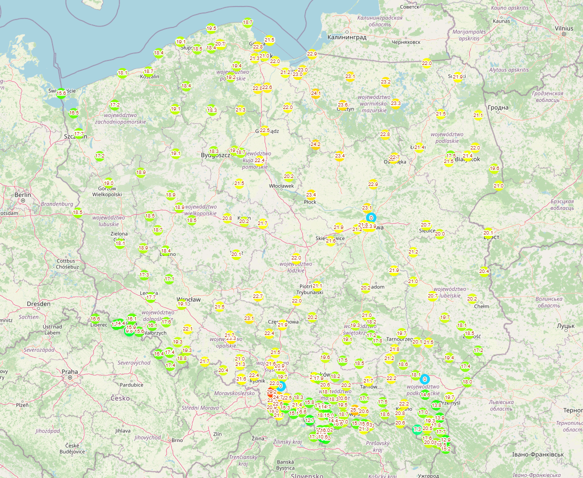

In [8]:
display_image(IMG_DIR / "map_stations.png", scale=0.5)

In [9]:
display_df(DATA_DIR / "input/voivodeships/weather_stations.csv")

,station_id,voivodeship,location
0,353150210,zachodniopomorskie,Resno-Smólsko
1,254170140,pomorskie,Kościerzyna
2,353200272,warmińsko-mazurskie,Olsztyn
3,351150400,lubuskie,Zielona Góra
4,352160330,wielkopolskie,Poznań


Among parameters collected by the stations we choose temperature, rainfall and humidity.


Preprocessing consisted of filtering out the data for stations mentioned above, 

In [10]:
run_notebook(SCRIPTS_DIR / "processing/weather.ipynb")
display_df(DATA_DIR / "intermediate/weather_measurements.csv")

,year,month,voivodeship,temperature,rainfall,humidity
0,2018,1,małopolskie,-1.149677,17.7,89.855484
1,2018,2,małopolskie,-2.167143,20.0,92.866429
2,2018,3,małopolskie,-0.725484,14.9,87.644194
3,2018,4,małopolskie,10.383333,17.7,72.174667
4,2018,5,małopolskie,17.081613,102.7,77.249677






### Voivodeship statistical data

The data comes from [GUS](https://bdl.stat.gov.pl/bdl/dane/podgrup/temat) _(Główny Urząd Statystyczny)_.

We considered the following data (on a per voivodeship bases) which we believe might be correlated with the total number of traffic incidents:
* population and population density
* vehicles registered
* the overall length of roads

The preprocessing involved extracting the values mentioned above from raw tables and merging them into one file.

In [11]:
run_notebook(SCRIPTS_DIR / "processing/voivodeships.ipynb")
display_df(DATA_DIR / "intermediate/voivodeships.csv")

,year,voivodeship,population_density,population,vehicles_count,roads_length
0,2018,dolnośląskie,145.4,2901.23,2274325,24333.4
1,2019,dolnośląskie,145.4,2900.16,2366425,24548.6
2,2020,dolnośląskie,145.8,2908.38,2448105,25322.3
3,2021,dolnośląskie,145.3,2897.74,2529725,25427.2
4,2022,dolnośląskie,144.8,2888.03,2592868,25562.7


### Data merging 

The data preprocessed above was merged together with respect to voivodeship, year and month.

In [12]:
run_notebook(SCRIPTS_DIR / "processing/merge.ipynb")
display_df(DATA_DIR / "intermediate/data_all.csv")

,year,month,voivodeship,temperature,rainfall,humidity,population_density,population,vehicles_count,roads_length,incidents
0,2018,1,małopolskie,-1.149677,17.7,89.855484,224.0,3400.58,2565658,31444.0,2879
1,2018,2,małopolskie,-2.167143,20.0,92.866429,224.0,3400.58,2565658,31444.0,2658
2,2018,3,małopolskie,-0.725484,14.9,87.644194,224.0,3400.58,2565658,31444.0,2741
3,2018,4,małopolskie,10.383333,17.7,72.174667,224.0,3400.58,2565658,31444.0,2848
4,2018,5,małopolskie,17.081613,102.7,77.249677,224.0,3400.58,2565658,31444.0,2909


### The preparation of model input samples

A single batch of data serving as a model input is data for a given voivodeship in a given year.

In [13]:
run_notebook(SCRIPTS_DIR / "processing/sample.ipynb")
display_df(DATA_DIR / "analysis/2021_mazowieckie.csv")

,year,month,voivodeship,temperature,rainfall,humidity,population_density,population,vehicles_count,roads_length,incidents
0,2021,1,mazowieckie,-1.480645,24.6,89.451613,155.0,5512.79,5424468,55810.2,4830
1,2021,2,mazowieckie,-4.246429,15.1,87.321429,155.0,5512.79,5424468,55810.2,4922
2,2021,3,mazowieckie,1.145161,15.1,86.225806,155.0,5512.79,5424468,55810.2,4717
3,2021,4,mazowieckie,6.150000,32.4,78.066667,155.0,5512.79,5424468,55810.2,4896
4,2021,5,mazowieckie,13.832258,69.6,77.161290,155.0,5512.79,5424468,55810.2,5902
